<a href="https://colab.research.google.com/github/AmerigoGiommetti/MLSA-code-summarization/blob/master/python_code_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
"""
ML-Based Python Code Summarization
Course: Machine Learning for Software Analysis

This project implements a machine learning model that generates
natural language summaries from Python code snippets.

Author: Amerigo Giommetti
Academic Year: 2025/2026
"""


'\nML-Based Python Code Summarization\nCourse: Machine Learning for Software Analysis\n\nThis project implements a machine learning model that generates\nnatural language summaries from Python code snippets.\n\nAuthor: Amerigo Giommetti\nAcademic Year: 2025/2026\n'

In [12]:
# ============================================================
# 1. Imports and Global Configuration
# ============================================================

#Tutte le librerie standard che serviranno per il progetto
import random
import math
import time

#Librerie necessarie per la manipolazione dei dati
import numpy as np
import pandas as pd

#Librerie necessarie per il machine learning
import torch
import torch.nn as nn
import torch.optim as optim

#Libreria per il plotting dei dati
import matplotlib.pyplot as plt
from tqdm import tqdm as tdqm

#Scelta della CPU o della GPU per processare i dati
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

SEED = 42                 #Seed per la riproducibilità dei risultati
BATCH_SIZE = 32           #Quanti dati si prendono alla volta
EMBEDDING_DIM = 128       #Complessità della rappresentazione che il modello fa dei dati
HIDDEN_DIM = 256          #Quantità di informazioni che il modello tiene ad ogni passaggio
NUM_EPOCHS = 20           #Numero di volte che i dati vengono processati
LEARNING_RATE = 1e-3      #Velocità con cui il modello impara
MAX_CODE_LEN = 200        #Lunghezza massima degli input di codice
MAX_SUMMARY_LEN = 75      #Lunghezza massima delle frasi summarization
MAX_SAMPLES = 5000        #Lunghezza massima del dataset per il training

Using device: cuda


In [13]:
# ============================================================
# 2. Reproducibility and Utility Functions
# ============================================================

#Setta lo stesso seed per tutti i processi random del modello
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
#Il seed che viene usato è quello definito sopra
set_seed(SEED)

#Helper function per l'aggiunta di padding negli input troppo corti
def pad_sequence(seq, max_len, pad_value=0):
    return seq[:max_len] + [pad_value] * max(0, max_len - len(seq))


In [14]:
# ============================================================
# 3. Dataset Loading and Preprocessing
# ============================================================

#Primo dataset "giocattolo" per il test end to end della pipeline
toy_data = [
    ("def add(x, y): return x + y", "returns the sum of two numbers"),
    ("def sub(x, y): return x - y", "returns the difference of two numbers"),
    ("def mul(x, y): return x * y", "returns the product of two numbers"),
]
#Divisione del dataset in input e target
codes, summaries = zip(*toy_data)

# ===========================================================================
# 3. Dataset Loading code_x_glue (Direct Download from S3/GitHub Source)
# ===========================================================================

#import per il dataset di huggingface
from datasets import load_dataset
#import per il train test split
from sklearn.model_selection import train_test_split

def load_data_final():
    print("Caricamento dataset CodeXGLUE (Python)...")
    # Questo dataset è la versione pulita e stabile per Code Summarization
    dataset = load_dataset("code_x_glue_ct_code_to_text", "python")

    # Prendiamo lo split di train e lo trasformiamo in DataFrame
    train_data = dataset['train'].select(range(5000)) # Limite a 5000 per velocità

    df = pd.DataFrame({
        'code': train_data['code'],
        'summary': train_data['docstring']
    })

    # Pulizia (come da Lecture 7)
    df['code'] = df['code'].str.replace(r'\s+', ' ', regex=True).str.strip()
    df['summary'] = df['summary'].str.replace(r'\s+', ' ', regex=True).str.strip()

    return df

train_df = load_data_final()
print(f"Dataset caricato! Righe: {len(train_df)}")
print(f"Esempio Summary: {train_df['summary'].iloc[0]}")


Caricamento dataset CodeXGLUE (Python)...
Dataset caricato! Righe: 5000
Esempio Summary: Set the text for this element. Arguments: text (str): The text cls (str): The class of the text, defaults to ``current`` (leave this unless you know what you are doing). There may be only one text content element of each class associated with the element.


In [15]:
# ============================================================
# 4. Vocabulary and Tokenization
# ============================================================

#Definizione delle parole speciali
SPECIAL_TOKENS = {
    "<pad>": 0,       #per la normalizzazione della lunghezza
    "<sos>": 1,       #start of sequence
    "<eos>": 2,       #end of sequence
    "<unk>": 3        #per parole assenti dal vocabolario
}

#Libreria per le espressioni regolari per la tokenizzazione del codice
import re

# tokenizzazione delle frasi usando parole
# e qualsiasi tipo di carattere speciale diverso
# dallo spazio come input diviso
def tokenize(sentence):
    sentence = sentence.lower()
    tokens = re.findall(r"\w+|[^\w\s]", sentence)
    return tokens

# Creazione del vocabolario con tutte le parole speciali e tutte
# quelle presenti nell'input di training
def build_vocab(sentences):
    vocab = dict(SPECIAL_TOKENS)
    for sent in sentences:
        for token in tokenize(sent):
            if token not in vocab:
                vocab[token] = len(vocab)
    return vocab

#Creazione di due vocabolari distinti per il codice e per il linguaggio naturale
code_vocab = build_vocab(train_df['code'])
summary_vocab = build_vocab(train_df['summary'])

# Encoding delle sequenze in input in numeri secondo i vocabolari appena creati
def encode(sentence, vocab, max_len):
    tokens = tokenize(sentence)
    ids = [vocab.get(tok, vocab["<unk>"]) for tok in tokens]
    ids = [vocab["<sos>"]] + ids + [vocab["<eos>"]]
    return pad_sequence(ids, max_len, vocab["<pad>"])

#Creazione dei tensor che serviranno per il machine learning
print("Encoding del codice...")
X = torch.tensor([encode(c, code_vocab, MAX_CODE_LEN) for c in tdqm(train_df['code'])]).to(DEVICE)
print("Encoding del summary...")
Y = torch.tensor([encode(s, summary_vocab, MAX_SUMMARY_LEN) for s in tdqm(train_df['summary'])]).to(DEVICE)


Encoding del codice...


100%|██████████| 5000/5000 [00:00<00:00, 10810.98it/s]


Encoding del summary...


100%|██████████| 5000/5000 [00:00<00:00, 29630.04it/s]


In [16]:
# ============================================================
# 5. Model Definition
# ============================================================

class Encoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, EMBEDDING_DIM)
        self.lstm = nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, batch_first=True)

    def forward(self, x):
        emb = self.embedding(x)
        _, (h, c) = self.lstm(emb)
        return h, c


class Decoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, EMBEDDING_DIM)
        self.lstm = nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, batch_first=True)
        self.fc = nn.Linear(HIDDEN_DIM, vocab_size)

    def forward(self, x, hidden):
        emb = self.embedding(x)
        out, hidden = self.lstm(emb, hidden)
        return self.fc(out), hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.fc.out_features

        # Tensor per memorizzare gli output del decoder
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # L'ultimo stato dell'Encoder diventa il primo del Decoder
        hidden, cell = self.encoder(src)

        # Il primo input del decoder è sempre il token <sos>
        input = trg[:, 0] # Prende la prima colonna (tutti i <sos>)

        for t in range(1, trg_len):
            # Passiamo l'input attuale e lo stato (h, c)
            output, (hidden, cell) = self.decoder(input.unsqueeze(1), (hidden, cell))

            # Memorizziamo la predizione
            outputs[:, t, :] = output.squeeze(1)

            # Decidiamo se usare Teacher Forcing
            top1 = output.argmax(2).squeeze(1)
            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[:, t] if teacher_force else top1

        return outputs


Epoch 1/20 - Loss: 6.2247
Epoch 2/20 - Loss: 5.5960
Epoch 3/20 - Loss: 5.3772
Epoch 4/20 - Loss: 5.2092
Epoch 5/20 - Loss: 5.1002
Epoch 6/20 - Loss: 5.0041
Epoch 7/20 - Loss: 4.9153
Epoch 8/20 - Loss: 4.8184
Epoch 9/20 - Loss: 4.7374
Epoch 10/20 - Loss: 4.6444
Epoch 11/20 - Loss: 4.5615
Epoch 12/20 - Loss: 4.4959
Epoch 13/20 - Loss: 4.4117
Epoch 14/20 - Loss: 4.3414
Epoch 15/20 - Loss: 4.2649
Epoch 16/20 - Loss: 4.2152
Epoch 17/20 - Loss: 4.1358
Epoch 18/20 - Loss: 4.0732
Epoch 19/20 - Loss: 4.0111
Epoch 20/20 - Loss: 3.9453


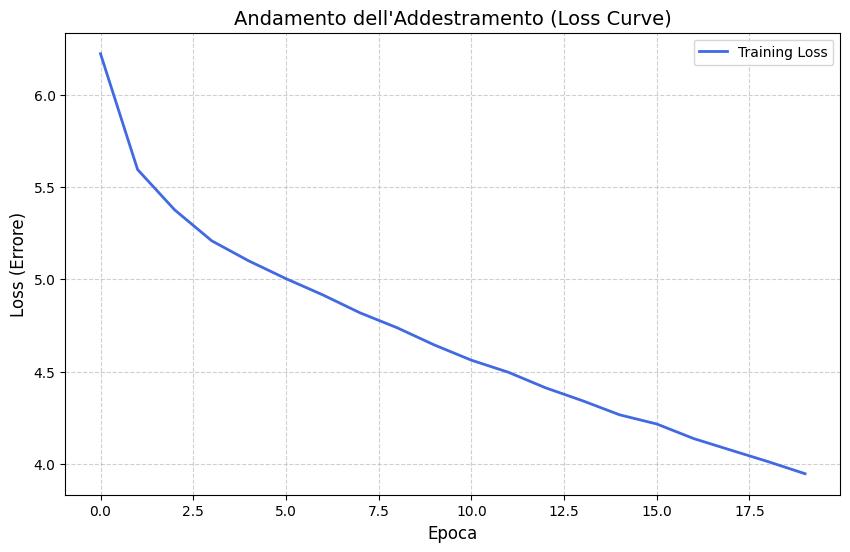

In [17]:
# ============================================================
# 6. Training Loop
# ============================================================

#Import necessario per il dataloader
from torch.utils.data import TensorDataset, DataLoader

#Usiamo il dataloader per non passare tutto il dataset in una volta
#Che potrebbe risultare in impossibilità di computazione per la CPU
dataset = TensorDataset(X, Y)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

#Questa variabile ci servirà per plottare la loss
train_losses = []

#Inizializzazione dell'encoder e del decoder, optimizer e loss
enc = Encoder(len(code_vocab)).to(DEVICE)
dec = Decoder(len(summary_vocab)).to(DEVICE)
model = Seq2Seq(enc, dec, DEVICE).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=0) #ignora il padding

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()

        # Ora passiamo tutto al modello Seq2Seq.
        # Lui si occuperà di gestire l'encoder, il decoder e il teacher forcing internamente.
        # batch_y[:, :-1] sono gli input per il decoder (<sos> + parole)
        # batch_y[:, 1:]  sono i target che vogliamo predire (parole + <eos>)
        outputs = model(batch_x, batch_y)

        # Il primo token dell'output (tempo 0) è zero o non usato,
        # confrontiamo dal tempo 1 in poi
        output_dim = outputs.shape[-1]

        # Flattening per la CrossEntropy:
        # [batch, seq_len, vocab] -> [batch * seq_len, vocab]
        loss = criterion(
            outputs[:, 1:, :].reshape(-1, output_dim),
            batch_y[:, 1:].reshape(-1)
        )

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss) #Salviamo la loss media di questo epoch
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {epoch_loss/len(train_loader):.4f}")

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='royalblue', linewidth=2)
plt.title('Andamento dell\'Addestramento (Loss Curve)', fontsize=14)
plt.xlabel('Epoca', fontsize=12)
plt.ylabel('Loss (Errore)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [18]:
# ============================================================
# 7. Evaluation Metrics
# ============================================================

print("Evaluation placeholder – metrics will be added later.")


Evaluation placeholder – metrics will be added later.


In [19]:
# ============================================================
# 8. Inference / Code Summarization
# ============================================================

def summarize_code(model, code_sentence, src_vocab, tgt_vocab, max_len=50):
    model.eval() # Imposta il modello in modalità valutazione (niente dropout)

    with torch.no_grad():
        # 1. Tokenizzazione e Encoding del codice in input
        tokens = tokenize(code_sentence)
        ids = [src_vocab.get(tok, src_vocab["<unk>"]) for tok in tokens]
        ids = [src_vocab["<sos>"]] + ids + [src_vocab["<eos>"]]
        src_tensor = torch.tensor(ids).unsqueeze(0).to(DEVICE) # [1, seq_len]

        # 2. Passaggio nell'Encoder
        hidden, cell = model.encoder(src_tensor)

        # 3. Preparazione per la generazione (partiamo da <sos>)
        inputs = [tgt_vocab["<sos>"]]

        for i in range(max_len):
            input_tensor = torch.tensor([inputs[-1]]).to(DEVICE)

            # 4. Il Decoder genera la parola successiva
            output, (hidden, cell) = model.decoder(input_tensor.unsqueeze(1), (hidden, cell))

            # Prende la parola con la probabilità più alta
            predicted_id = output.argmax(dim=2).item()
            inputs.append(predicted_id)

            # 5. Se il modello genera <eos>, la frase è finita
            if predicted_id == tgt_vocab["<eos>"]:
                break

        # 6. Convertiamo gli ID in parole leggibili (saltando <sos> e <eos>)
        summary_tokens = [tgt_vocab_inv[idx] for idx in inputs if idx not in [SPECIAL_TOKENS["<sos>"], SPECIAL_TOKENS["<eos>"], SPECIAL_TOKENS["<pad>"]]]
        return " ".join(summary_tokens)

# Creiamo un dizionario inverso per decodificare (ID -> Parola)
tgt_vocab_inv = {v: k for k, v in summary_vocab.items()}

#================================================================
# Confronto tra frasi attese e frasi prodotte
#================================================================
def run_test_samples(n=5):
    print(f"{'CODICE ORIGINALE':<50} | {'RIASSUNTO REALE':<30} | {'GENERATO'}")
    print("-" * 130)

    # Usiamo train_df (o val_df se l'hai creato) per recuperare i testi
    for i in range(n):
        idx = random.randint(0, len(train_df)-1)
        original_code = train_df.iloc[idx]['code']
        real_summary = train_df.iloc[idx]['summary']

        generated_summary = summarize_code(model, original_code, code_vocab, summary_vocab)

        # Visualizzazione formattata
        short_code = (original_code[:47] + '...') if len(original_code) > 47 else original_code
        short_real = (real_summary[:27] + '...') if len(real_summary) > 27 else real_summary

        print(f"{short_code:<50} | {short_real:<30} | {generated_summary}")

# Eseguiamo il test
run_test_samples(n=5)


CODICE ORIGINALE                                   | RIASSUNTO REALE                | GENERATO
----------------------------------------------------------------------------------------------------------------------------------
def make_label(id_, lineno): """ Creates a labe... | Creates a label entry. Retu... | get a file to to a file file .
def set_abstract(self, xml_dict): """ If record... | If record has an abstract, ... | run to to a file file . . the file or file file .
def extracturls(mesg): """Given a text message,... | Given a text message, extra... | return a " " " " " " " " " " " " " " " " " " " " " " : " : " : " : " : " : " : " : " : " : " : " : " : "
def domain(value, allow_empty = False, allow_ip... | Validate that ``value`` is ... | register a ` ` ` ` ` ` ` ` . : param : : the value to validate . : type : : : class : ` ~ ` : param : : ` ` ` ` ` ` ` ` ` ` ` ` ` ` ` `
def similarity(self, track): """ Compares two t... | Compares two tracks based o... | a a that fetches and t

In [20]:
# ============================================================
# 9. Main Execution
# ============================================================

print("Project execution completed.")


Project execution completed.
